🔍 Searching for 'best_summary.csv' inside ./runs_ml/GTSRB...
✅ Found file at: ./runs_ml/GTSRB/target/best_summary.csv
💾 Plot saved to: analyse_plot/feature_extraction_time_GTSRB.png


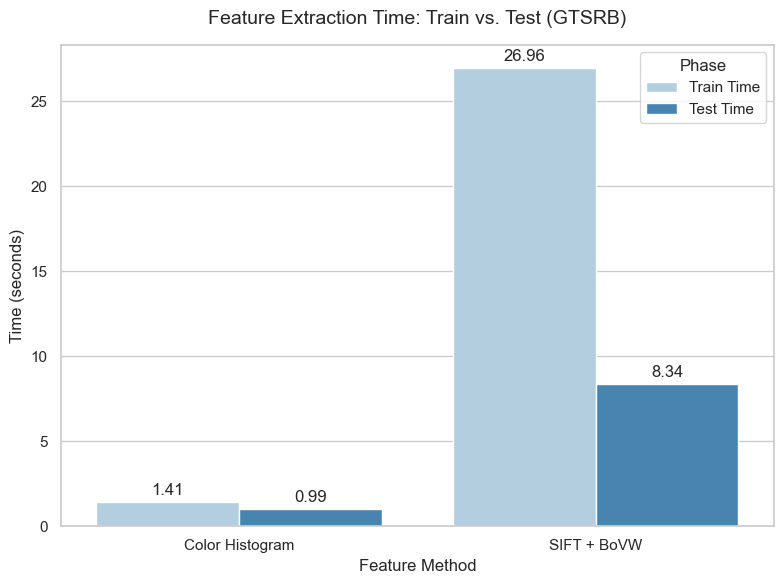

In [80]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
DATASET_NAME = "GTSRB"   # "GTSRB" oder "CIFAR10"
ROOT_DIR = "./runs_ml" 
OUTPUT_FOLDER = "analyse_plot"

def plot_feature_extraction_time(root_dir, dataset_name):
    # 1. Pfad zum Datensatz konstruieren
    dataset_path = os.path.join(root_dir, dataset_name)
    
    if not os.path.exists(dataset_path):
        print(f"❌ Dataset folder not found: {dataset_path}")
        return

    # 2. Rekursiv nach 'best_summary.csv' suchen
    csv_path = None
    print(f"🔍 Searching for 'best_summary.csv' inside {dataset_path}...")
    
    for root, dirs, files in os.walk(dataset_path):
        if "best_summary.csv" in files:
            csv_path = os.path.join(root, "best_summary.csv")
            print(f"✅ Found file at: {csv_path}")
            break 
    
    if not csv_path:
        print(f"⚠️ Could not find 'best_summary.csv' in {dataset_name}.")
        return

    # 3. Daten laden
    df = pd.read_csv(csv_path)
    
    # ---------------------------------------------------------
    # HIER PASSIERT DIE UMBENENNUNG DER X-ACHSE
    # ---------------------------------------------------------
    feature_name_map = {
        "ColorHist_bins8": "Color Histogram",
        "SIFT_BoVW": "SIFT + BoVW",
        # Falls du später HOG oder andere hast, hier ergänzen:
        # "HOG": "HOG Descriptor"
    }
    
    # Wir wenden das Mapping an, bevor wir filtern
    df["feature"] = df["feature"].replace(feature_name_map)

    # 4. Daten verarbeiten
    feat_df = df[["feature", "feat_time_train_s", "feat_time_test_s"]].drop_duplicates()
    
    plot_df = feat_df.melt(id_vars="feature", 
                           value_vars=["feat_time_train_s", "feat_time_test_s"],
                           var_name="Phase", 
                           value_name="Time (s)")
    
    # Legendennamen verschönern
    plot_df["Phase"] = plot_df["Phase"].replace({
        "feat_time_train_s": "Train Time", 
        "feat_time_test_s": "Test Time"
    })

    # 5. Plotten
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 6))
    
    ax = sns.barplot(data=plot_df, x="feature", y="Time (s)", hue="Phase", palette="Blues")
    
    # Werte über Balken
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)

    plt.title(f"Feature Extraction Time: Train vs. Test ({dataset_name})", fontsize=14, pad=15)
    plt.ylabel("Time (seconds)", fontsize=12)
    plt.xlabel("Feature Method", fontsize=12) # Achsenbeschriftung bleibt allgemein
    plt.legend(title="Phase")
    plt.tight_layout()
    
    # 6. Speichern
    save_filename = f"feature_extraction_time_{dataset_name}.png"
    save_path = os.path.join(OUTPUT_FOLDER, save_filename)
    plt.savefig(save_path, dpi=300)
    
    print(f"💾 Plot saved to: {save_path}")
    plt.show()

# --- RUN ---
plot_feature_extraction_time(ROOT_DIR, DATASET_NAME)

🔍 Durchsuche /Users/Ahnaf/Library/CloudStorage/OneDrive-VerkehrsverbundOst-Region(VOR)GmbH/TU/ML/ML_Ex3/ML_UE3-main/runs_ml nach 'best_summary.csv'...
  ✅ Gefunden für GTSRB: ./runs_ml/GTSRB/target/best_summary.csv
  ✅ Gefunden für CIFAR10: ./runs_ml/CIFAR10/target/best_summary.csv
💾 Plot gespeichert: analyse_plot/feature_extraction_comparison_combined.png


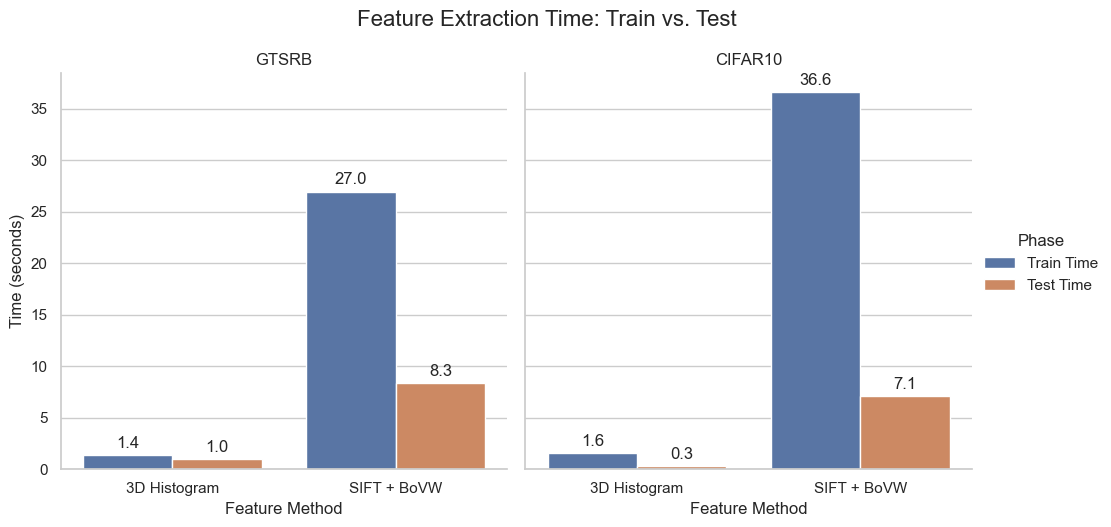

In [81]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
ROOT_DIR = "./runs_ml"  # Der Überordner, der GTSRB und CIFAR enthält
OUTPUT_FOLDER = "analyse_plot"

def plot_combined_feature_times(root_dir):
    all_data = []
    
    print(f"🔍 Durchsuche {os.path.abspath(root_dir)} nach 'best_summary.csv'...")

    # 1. Alle best_summary.csv Dateien finden
    for root, dirs, files in os.walk(root_dir):
        if "best_summary.csv" in files:
            file_path = os.path.join(root, "best_summary.csv")
            
            # Datensatz-Name aus dem Pfad erraten
            path_lower = root.lower()
            if "gtsrb" in path_lower:
                dataset_name = "GTSRB"
            elif "cifar" in path_lower:
                dataset_name = "CIFAR10"
            else:
                continue # Unbekannte Ordner überspringen

            print(f"  ✅ Gefunden für {dataset_name}: {file_path}")

            # Laden
            df = pd.read_csv(file_path)
            
            # Nur Feature-Zeiten behalten (Duplikate entfernen)
            feat_df = df[["feature", "feat_time_train_s", "feat_time_test_s"]].drop_duplicates()
            feat_df["Dataset"] = dataset_name # Spalte für Faceting hinzufügen
            
            all_data.append(feat_df)

    if not all_data:
        print("❌ Keine Daten gefunden. Überprüfe den Pfad.")
        return

    # 2. Zusammenfügen & Umformen
    full_df = pd.concat(all_data, ignore_index=True)
    
    # Feature Namen verschönern (X-Achse)
    feature_map = {
        "ColorHist_bins8": "3D Histogram",
        "SIFT_BoVW": "SIFT + BoVW"
    }
    full_df["feature"] = full_df["feature"].replace(feature_map)

    # Melt (Wide -> Long Format)
    plot_df = full_df.melt(id_vars=["feature", "Dataset"], 
                           value_vars=["feat_time_train_s", "feat_time_test_s"],
                           var_name="Phase", 
                           value_name="Time (s)")
    
    # Phase Namen verschönern (Legende)
    plot_df["Phase"] = plot_df["Phase"].replace({
        "feat_time_train_s": "Train Time", 
        "feat_time_test_s": "Test Time"
    })

    # 3. Plotten (Side-by-Side mit gleicher Skala)
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    sns.set_theme(style="whitegrid")
    
    g = sns.catplot(
        data=plot_df, 
        kind="bar", 
        x="feature", 
        y="Time (s)", 
        hue="Phase", 
        col="Dataset",     # Zwei Spalten (GTSRB, CIFAR)
        height=5, 
        aspect=1,
        sharey=True        # WICHTIG: Gleiche Skala für beide Plots!
    )

    # Titel und Labels
    g.fig.suptitle("Feature Extraction Time: Train vs. Test", y=1.05, fontsize=16)
    g.set_axis_labels("Feature Method", "Time (seconds)")
    g.set_titles("{col_name}") 

    # Werte über die Balken schreiben
    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f', padding=3)

    # 4. Speichern
    save_path = os.path.join(OUTPUT_FOLDER, "feature_extraction_comparison_combined.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Plot gespeichert: {save_path}")
    plt.show()

# Ausführen
plot_combined_feature_times(ROOT_DIR)

🔍 Suche nach Random Forest GridSearch-Daten in ./runs_ml...
  ✅ Geladen: GTSRB | Color Histogram (9 Zeilen)
  ✅ Geladen: GTSRB | SIFT (BoW) (9 Zeilen)
  ✅ Geladen: CIFAR-10 | SIFT (BoW) (9 Zeilen)
  ✅ Geladen: CIFAR-10 | Color Histogram (9 Zeilen)

📊 Erstelle Plot...
💾 Plot erfolgreich gespeichert: analyse_plot/rf_gridsearch_full_comparison.png


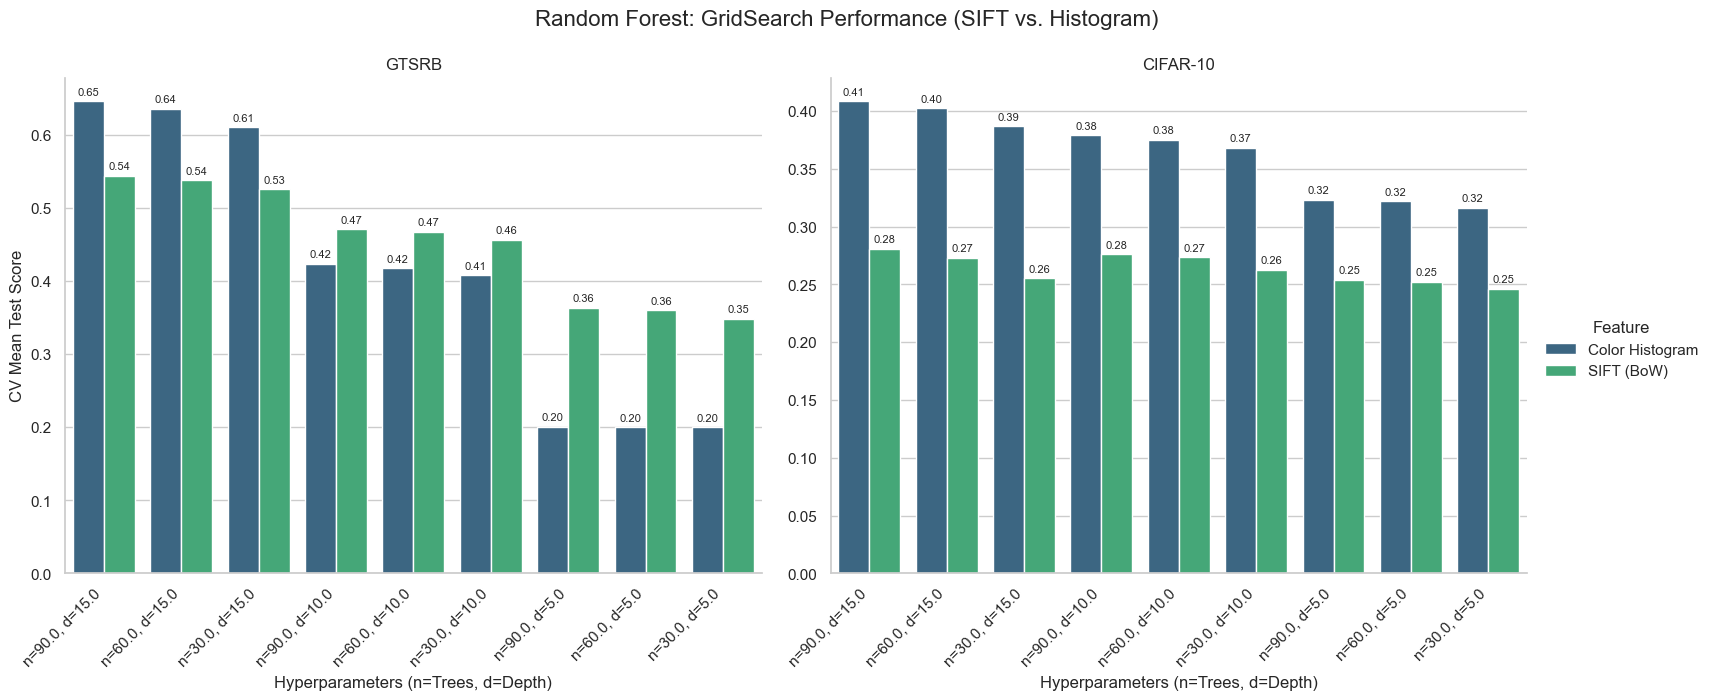

In [82]:
import os
import json
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- KONFIGURATION ---
ROOT_PATH = "./runs_ml"  # Dein Pfad
OUTPUT_FOLDER = "analyse_plot"

def analyze_rf_gridsearch_plots_robust(root_path):
    all_data = []
    
    print(f"🔍 Suche nach Random Forest GridSearch-Daten in {root_path}...")
    
    for root, dirs, files in os.walk(root_path):
        if "config.json" in files:
            try:
                # 1. Config laden
                with open(os.path.join(root, "config.json"), 'r') as f:
                    config = json.load(f)
                
                # 2. Ist es Random Forest?
                model = config.get("model", "").lower()
                if "rf" not in model and "random" not in model:
                    continue 

                # 3. Welcher Datensatz?
                cfg_dataset = config.get("dataset", "").lower()
                path_lower = root.lower()
                
                if "gtsrb" in cfg_dataset or "gtsrb" in path_lower:
                    dataset_name = "GTSRB"
                elif "cifar" in cfg_dataset or "cifar" in path_lower:
                    dataset_name = "CIFAR-10"
                else:
                    dataset_name = "Unknown"

                # 4. Welches Feature?
                feature_raw = config.get("feature", "Unknown")
                if "ColorHist" in feature_raw: feature = "Color Histogram"
                elif "SIFT" in feature_raw: feature = "SIFT (BoW)"
                else: feature = feature_raw

                # 5. Results CSV laden
                # Wir suchen nach results.csv oder result.csv
                csv_filename = "results.csv" if "results.csv" in files else ("result.csv" if "result.csv" in files else None)
                
                if csv_filename:
                    csv_path = os.path.join(root, csv_filename)
                    df = pd.read_csv(csv_path)
                    
                    # --- A) Score Spalte finden ---
                    score_col = None
                    if "cv_mean_test_score" in df.columns: score_col = "cv_mean_test_score"
                    elif "mean_test_score" in df.columns: score_col = "mean_test_score"
                    
                    if not score_col:
                        print(f"  ⚠️ Keine Score-Spalte in {csv_path} (Suche nach mean_test_score)")
                        continue

                    # --- B) Parameter Labels bauen ---
                    # Fall 1: Spalte 'params' existiert (String Dictionary)
                    if "params" in df.columns:
                        def parse_params(p_str):
                            try:
                                d = ast.literal_eval(p_str)
                                parts = []
                                if "n_estimators" in d: parts.append(f"n={d['n_estimators']}")
                                if "max_depth" in d: parts.append(f"d={d['max_depth']}")
                                return ", ".join(parts)
                            except:
                                return str(p_str)
                        df["Params_Label"] = df["params"].apply(parse_params)
                    
                    # Fall 2: Parameter sind eigene Spalten (n_estimators, max_depth)
                    elif "n_estimators" in df.columns and "max_depth" in df.columns:
                        def build_label(row):
                            return f"n={row['n_estimators']}, d={row['max_depth']}"
                        df["Params_Label"] = df.apply(build_label, axis=1)
                    
                    else:
                        print(f"  ⚠️ Keine Parameter-Spalten in {csv_path} gefunden.")
                        continue

                    # Daten speichern
                    df["Dataset"] = dataset_name
                    df["Feature"] = feature
                    df["Score"] = df[score_col]
                    
                    all_data.append(df[["Dataset", "Feature", "Params_Label", "Score"]])
                    print(f"  ✅ Geladen: {dataset_name} | {feature} ({len(df)} Zeilen)")
                    
                else:
                    print(f"  ⚠️ Keine CSV in {root}")

            except Exception as e:
                print(f"  ❌ Fehler in {root}: {e}")

    if not all_data:
        print("❌ Keine passenden Daten gefunden.")
        return

    # --- PLOTTING ---
    print("\n📊 Erstelle Plot...")
    full_df = pd.concat(all_data, ignore_index=True)
    
    # Optional: Unknown filtern
    full_df = full_df[full_df["Dataset"] != "Unknown"]

    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    sns.set_theme(style="whitegrid")

    g = sns.catplot(
        data=full_df,
        kind="bar",
        x="Params_Label",
        y="Score",
        hue="Feature",
        col="Dataset",
        height=6, 
        aspect=1.3,
        sharey=False, 
        palette="viridis",
        errorbar=None
    )

    g.fig.suptitle("Random Forest: GridSearch Performance (SIFT vs. Histogram)", y=1.05, fontsize=16)
    g.set_axis_labels("Hyperparameters (n=Trees, d=Depth)", "CV Mean Test Score")
    g.set_titles("{col_name}")

    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha("right")
        
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)

    save_path = os.path.join(OUTPUT_FOLDER, "rf_gridsearch_full_comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(f"💾 Plot erfolgreich gespeichert: {save_path}")
    plt.show()

# Ausführen
if __name__ == "__main__":
    analyze_rf_gridsearch_plots_robust(ROOT_PATH)

🔍 Suche nach Logistic Regression GridSearch-Daten in ./runs_ml...
  ✅ Geladen: GTSRB | SIFT (BoW) (10 Zeilen)
  ✅ Geladen: GTSRB | Color Histogram (10 Zeilen)
  ✅ Geladen: CIFAR-10 | SIFT (BoW) (10 Zeilen)
  ✅ Geladen: CIFAR-10 | Color Histogram (10 Zeilen)

📊 Erstelle Plot...
💾 Plot erfolgreich gespeichert: analyse_plot/lr_gridsearch_full_comparison.png


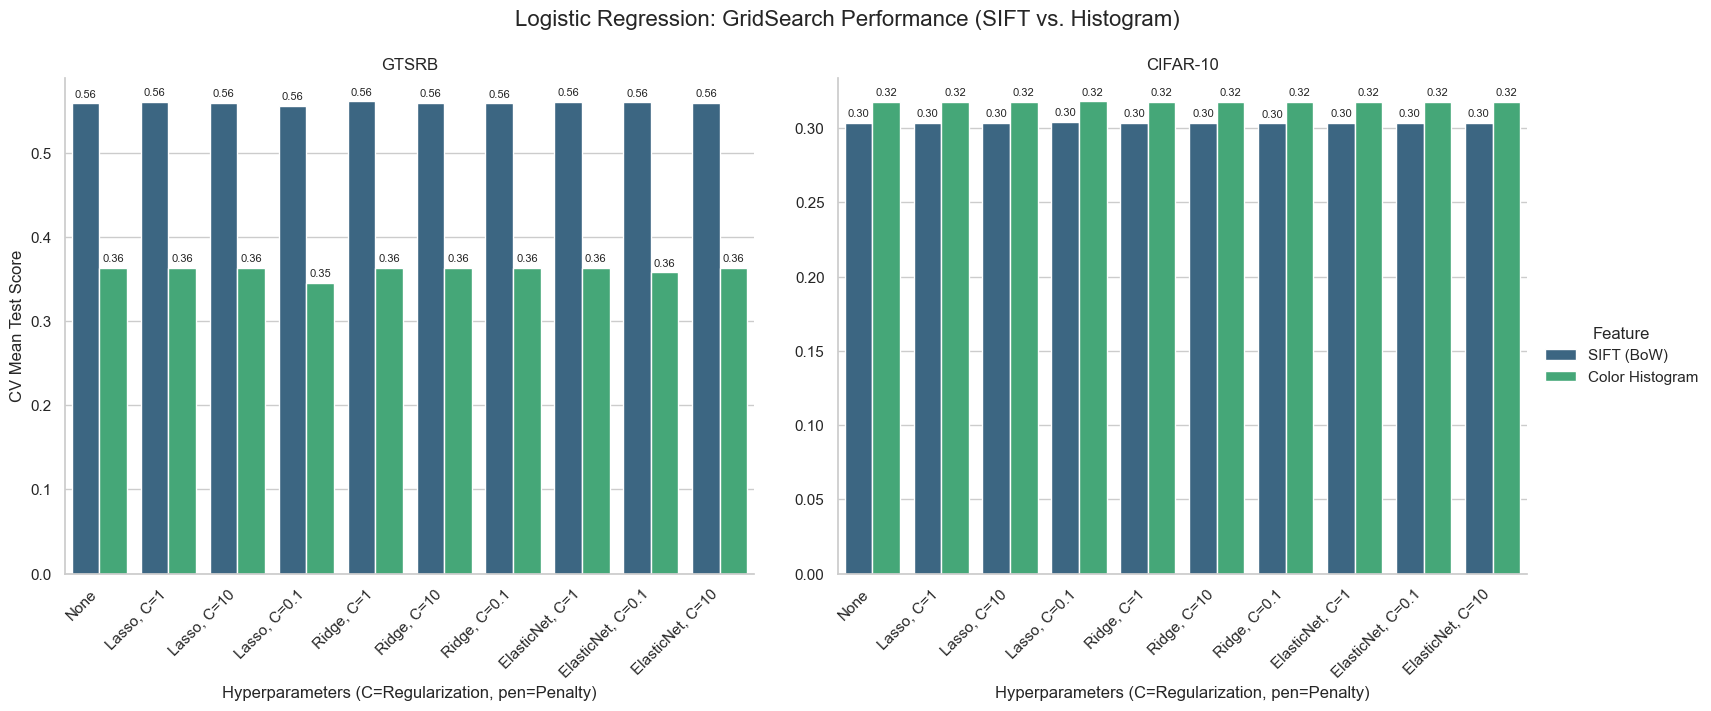

In [83]:
import os
import json
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- KONFIGURATION ---
ROOT_PATH = "./runs_ml"  # Dein Pfad
OUTPUT_FOLDER = "analyse_plot"

def analyze_lr_gridsearch_plots_robust(root_path):
    all_data = []
    
    print(f"🔍 Suche nach Logistic Regression GridSearch-Daten in {root_path}...")
    
    for root, dirs, files in os.walk(root_path):
        if "config.json" in files:
            try:
                # 1. Config laden
                with open(os.path.join(root, "config.json"), 'r') as f:
                    config = json.load(f)
                
                # 2. Ist es Logistic Regression?
                model = config.get("model", "").lower()
                if "lr" not in model and "logistic" not in model:
                    continue 

                # 3. Welcher Datensatz?
                cfg_dataset = config.get("dataset", "").lower()
                path_lower = root.lower()
                
                if "gtsrb" in cfg_dataset or "gtsrb" in path_lower:
                    dataset_name = "GTSRB"
                elif "cifar" in cfg_dataset or "cifar" in path_lower:
                    dataset_name = "CIFAR-10"
                else:
                    dataset_name = "Unknown"

                # 4. Welches Feature?
                feature_raw = config.get("feature", "Unknown")
                if "ColorHist" in feature_raw: feature = "Color Histogram"
                elif "SIFT" in feature_raw: feature = "SIFT (BoW)"
                else: feature = feature_raw

                # 5. Results CSV laden
                # Wir suchen nach results.csv oder result.csv
                csv_filename = "results.csv" if "results.csv" in files else ("result.csv" if "result.csv" in files else None)
                
                if csv_filename:
                    csv_path = os.path.join(root, csv_filename)
                    df = pd.read_csv(csv_path)
                    
                    # --- A) Score Spalte finden ---
                    score_col = None
                    if "cv_mean_test_score" in df.columns: score_col = "cv_mean_test_score"
                    elif "mean_test_score" in df.columns: score_col = "mean_test_score"
                    
                    if not score_col:
                        print(f"  ⚠️ Keine Score-Spalte in {csv_path} (Suche nach mean_test_score)")
                        continue

                    # --- B) Parameter Labels bauen ---
                    # Für Logistic Regression: penalty-Spalte + params kombinieren
                    if "penalty" in df.columns and "params" in df.columns:
                        def build_lr_label(row):
                            penalty = row["penalty"]
                            # Kurze Penalty-Namen
                            penalty_short = {
                                "no_penalty": "None",
                                "l1_lasso": "Lasso",
                                "l2_ridge": "Ridge",
                                "elasticnet": "ElasticNet"
                            }.get(penalty, penalty)
                            
                            # C-Wert aus params extrahieren
                            try:
                                params_dict = ast.literal_eval(row["params"])
                                if params_dict:  # Wenn params nicht leer ist
                                    c_val = params_dict.get("clf__C", params_dict.get("C", "?"))
                                    return f"{penalty_short}, C={c_val}"
                                else:  # no_penalty hat leere params {}
                                    return f"{penalty_short}"
                            except:
                                return f"{penalty_short}"
                        
                        df["Params_Label"] = df.apply(build_lr_label, axis=1)
                    
                    # Fallback: Alte Logik für andere Strukturen
                    elif "params" in df.columns:
                        def parse_params(p_str):
                            try:
                                d = ast.literal_eval(p_str)
                                parts = []
                                if "C" in d: parts.append(f"C={d['C']}")
                                if "penalty" in d: parts.append(f"pen={d['penalty']}")
                                return ", ".join(parts)
                            except:
                                return str(p_str)
                        df["Params_Label"] = df["params"].apply(parse_params)
                    
                    else:
                        print(f"  ⚠️ Keine Parameter-Spalten in {csv_path} gefunden.")
                        continue

                    # Daten speichern
                    df["Dataset"] = dataset_name
                    df["Feature"] = feature
                    df["Score"] = df[score_col]
                    
                    all_data.append(df[["Dataset", "Feature", "Params_Label", "Score"]])
                    print(f"  ✅ Geladen: {dataset_name} | {feature} ({len(df)} Zeilen)")
                    
                else:
                    print(f"  ⚠️ Keine CSV in {root}")

            except Exception as e:
                print(f"  ❌ Fehler in {root}: {e}")

    if not all_data:
        print("❌ Keine passenden Daten gefunden.")
        return

    # --- PLOTTING ---
    print("\n📊 Erstelle Plot...")
    full_df = pd.concat(all_data, ignore_index=True)
    
    # Optional: Unknown filtern
    full_df = full_df[full_df["Dataset"] != "Unknown"]

    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    sns.set_theme(style="whitegrid")

    g = sns.catplot(
        data=full_df,
        kind="bar",
        x="Params_Label",
        y="Score",
        hue="Feature",
        col="Dataset",
        height=6, 
        aspect=1.3,
        sharey=False, 
        palette="viridis",
        errorbar=None
    )

    g.fig.suptitle("Logistic Regression: GridSearch Performance (SIFT vs. Histogram)", y=1.05, fontsize=16)
    g.set_axis_labels("Hyperparameters (C=Regularization, pen=Penalty)", "CV Mean Test Score")
    g.set_titles("{col_name}")

    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha("right")
        
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)

    save_path = os.path.join(OUTPUT_FOLDER, "lr_gridsearch_full_comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(f"💾 Plot erfolgreich gespeichert: {save_path}")
    plt.show()

# Ausführen
if __name__ == "__main__":
    analyze_lr_gridsearch_plots_robust(ROOT_PATH)

🔍 Suche nach Random Forest Runtimes in ./runs_ml...
  ✅ Runtimes geladen: GTSRB | Color Histogram
  ✅ Runtimes geladen: GTSRB | SIFT (BoW)
  ✅ Runtimes geladen: CIFAR-10 | SIFT (BoW)
  ✅ Runtimes geladen: CIFAR-10 | Color Histogram

📊 Erstelle Runtime-Plot...
💾 Plot gespeichert: analyse_plot/rf_gridsearch_runtime.png


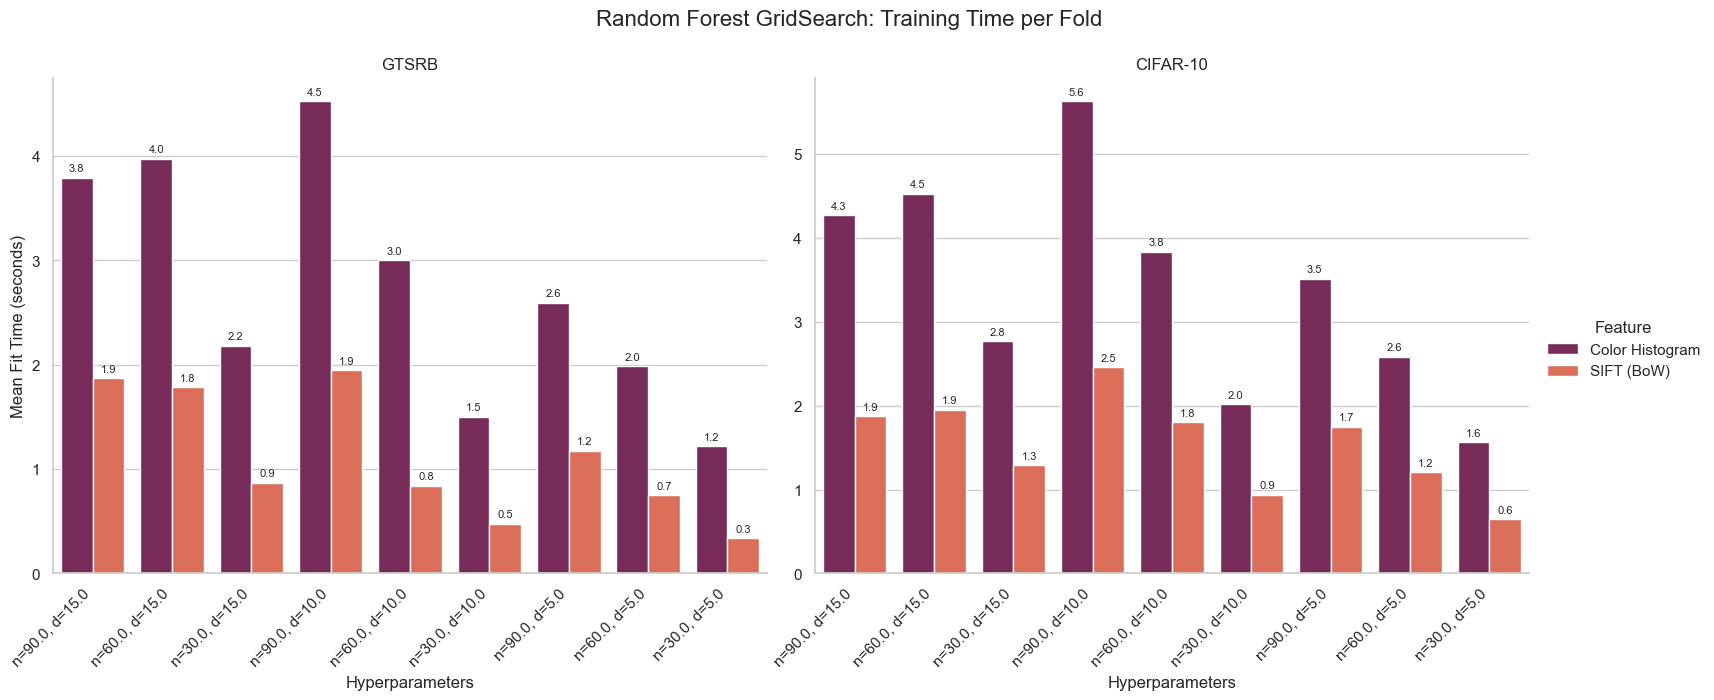

In [84]:
import os
import json
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
ROOT_PATH = "./runs_ml"
OUTPUT_FOLDER = "analyse_plot"

def analyze_rf_runtime_plot(root_path):
    all_data = []
    print(f"🔍 Suche nach Random Forest Runtimes in {root_path}...")
    for root, dirs, files in os.walk(root_path):
        if "config.json" in files:
            try:
                # 1. Config laden
                with open(os.path.join(root, "config.json"), 'r') as f:
                    config = json.load(f)
                # Filter: Nur Random Forest
                model = config.get("model", "").lower()
                if "rf" not in model and "random" not in model:
                    continue
                # Datensatz & Feature
                cfg_dataset = config.get("dataset", "").lower()
                path_lower = root.lower()
                if "gtsrb" in cfg_dataset or "gtsrb" in path_lower:
                    dataset_name = "GTSRB"
                elif "cifar" in cfg_dataset or "cifar" in path_lower:
                    dataset_name = "CIFAR-10"
                else:
                    dataset_name = "Unknown"
                feature_raw = config.get("feature", "Unknown")
                if "ColorHist" in feature_raw: feature = "Color Histogram"
                elif "SIFT" in feature_raw: feature = "SIFT (BoW)"
                else: feature = feature_raw
                # CSV laden
                csv_filename = "results.csv" if "results.csv" in files else ("result.csv" if "result.csv" in files else None)
                if csv_filename:
                    csv_path = os.path.join(root, csv_filename)
                    df = pd.read_csv(csv_path)
                    # Parameter Label bauen
                    if "params" in df.columns:
                        def parse_params(p_str):
                            try:
                                d = ast.literal_eval(p_str)
                                parts = []
                                if "n_estimators" in d: parts.append(f"n={d['n_estimators']}")
                                if "max_depth" in d: parts.append(f"d={d['max_depth']}")
                                return ", ".join(parts)
                            except:
                                return str(p_str)
                        df["Params_Label"] = df["params"].apply(parse_params)
                    elif "n_estimators" in df.columns and "max_depth" in df.columns:
                        def build_label(row):
                            return f"n={row['n_estimators']}, d={row['max_depth']}"
                        df["Params_Label"] = df.apply(build_label, axis=1)
                    else:
                        continue
                    # WICHTIG: Wir nutzen jetzt 'mean_fit_time' statt Score
                    if "mean_fit_time" in df.columns:
                        df["Time"] = df["mean_fit_time"]
                    else:
                        print(f"  ⚠️ Keine 'mean_fit_time' in {csv_path}")
                        continue
                    df["Dataset"] = dataset_name
                    df["Feature"] = feature
                    # Speichern
                    all_data.append(df[["Dataset", "Feature", "Params_Label", "Time"]])
                    print(f"  ✅ Runtimes geladen: {dataset_name} | {feature}")
            except Exception as e:
                print(f"  ❌ Fehler in {root}: {e}")
    if not all_data:
        print("❌ Keine Daten gefunden.")
        return
    
    # --- PLOTTING ---
    print("\n📊 Erstelle Runtime-Plot...")
    full_df = pd.concat(all_data, ignore_index=True)
    full_df = full_df[full_df["Dataset"] != "Unknown"]
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    sns.set_theme(style="whitegrid")
    # Runtime Plot
    g = sns.catplot(
        data=full_df,
        kind="bar",
        x="Params_Label",
        y="Time",
        hue="Feature",
        col="Dataset",
        height=6,
        aspect=1.3,
        sharey=False,   # Laufzeiten können sehr unterschiedlich sein
        palette="rocket", # Neue Farbpalette (Rot/Lila Töne)
        errorbar=None   # KEINE Fehlerbalken
    )
    g.fig.suptitle("Random Forest GridSearch: Training Time per Fold", y=1.05, fontsize=16)
    g.set_axis_labels("Hyperparameters", "Mean Fit Time (seconds)")
    g.set_titles("{col_name}")
    # Logarithmische Skala, da SIFT oft 100x langsamer ist
    # Wenn du das nicht willst, kommentiere die nächste Zeile aus (#)
    # g.set(yscale="log")  # <--- DIESE ZEILE WURDE AUSKOMMENTIERT
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha("right")
        # Wertebeschriftung
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f', padding=3, fontsize=8)
    save_path = os.path.join(OUTPUT_FOLDER, "rf_gridsearch_runtime.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Plot gespeichert: {save_path}")
    plt.show()

if __name__ == "__main__":
    analyze_rf_runtime_plot(ROOT_PATH)

🔍 Suche nach Logistic Regression Runtimes in ./runs_ml...
  ✅ Runtimes geladen: GTSRB | SIFT (BoW)
  ✅ Runtimes geladen: GTSRB | Color Histogram
  ✅ Runtimes geladen: CIFAR-10 | SIFT (BoW)
  ✅ Runtimes geladen: CIFAR-10 | Color Histogram

📊 Erstelle Runtime-Plot...
💾 Plot gespeichert: analyse_plot/lr_gridsearch_runtime.png


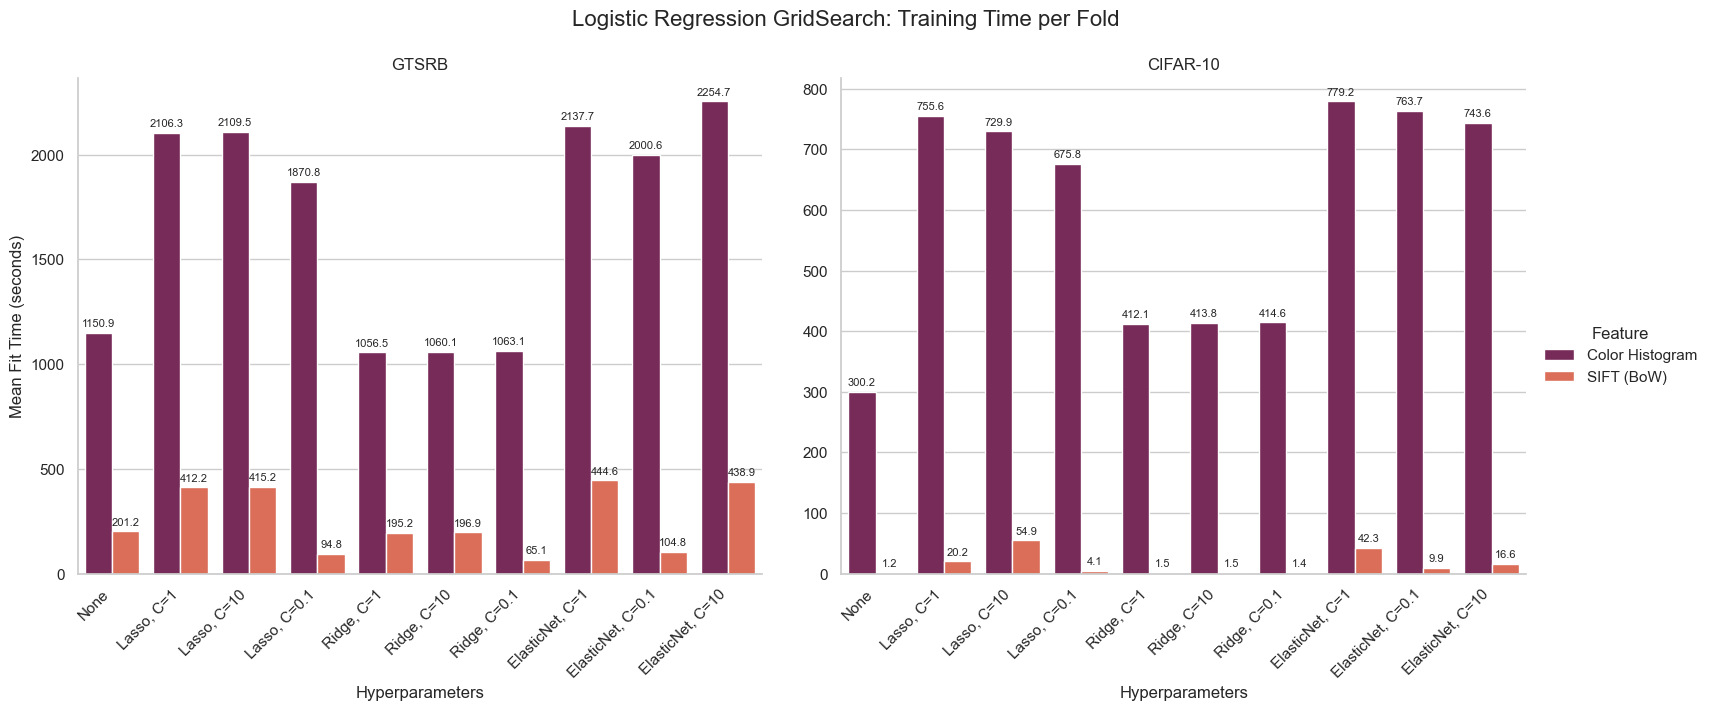

In [85]:
import os
import json
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
ROOT_PATH = "./runs_ml"  
OUTPUT_FOLDER = "analyse_plot"

def analyze_lr_runtime_plot(root_path):
    all_data = []
    
    print(f"🔍 Suche nach Logistic Regression Runtimes in {root_path}...")
    
    for root, dirs, files in os.walk(root_path):
        if "config.json" in files:
            try:
                # 1. Config laden
                with open(os.path.join(root, "config.json"), 'r') as f:
                    config = json.load(f)
                
                # Filter: Nur Logistic Regression
                model = config.get("model", "").lower()
                if "lr" not in model and "logistic" not in model:
                    continue 
                
                # Datensatz & Feature
                cfg_dataset = config.get("dataset", "").lower()
                path_lower = root.lower()
                
                if "gtsrb" in cfg_dataset or "gtsrb" in path_lower:
                    dataset_name = "GTSRB"
                elif "cifar" in cfg_dataset or "cifar" in path_lower:
                    dataset_name = "CIFAR-10"
                else:
                    dataset_name = "Unknown"
                
                feature_raw = config.get("feature", "Unknown")
                if "ColorHist" in feature_raw: feature = "Color Histogram"
                elif "SIFT" in feature_raw: feature = "SIFT (BoW)"
                else: feature = feature_raw
                
                # CSV laden
                csv_filename = "results.csv" if "results.csv" in files else ("result.csv" if "result.csv" in files else None)
                
                if csv_filename:
                    csv_path = os.path.join(root, csv_filename)
                    df = pd.read_csv(csv_path)
                    
                    # Parameter Label bauen (Logistic Regression spezifisch)
                    if "penalty" in df.columns and "params" in df.columns:
                        def build_lr_label(row):
                            penalty = row["penalty"]
                            # Kurze Penalty-Namen
                            penalty_short = {
                                "no_penalty": "None",
                                "l1_lasso": "Lasso",
                                "l2_ridge": "Ridge",
                                "elasticnet": "ElasticNet"
                            }.get(penalty, penalty)
                            
                            # C-Wert aus params extrahieren
                            try:
                                params_dict = ast.literal_eval(row["params"])
                                if params_dict:  # Wenn params nicht leer ist
                                    c_val = params_dict.get("clf__C", params_dict.get("C", "?"))
                                    return f"{penalty_short}, C={c_val}"
                                else:  # no_penalty hat leere params {}
                                    return f"{penalty_short}"
                            except:
                                return f"{penalty_short}"
                        
                        df["Params_Label"] = df.apply(build_lr_label, axis=1)
                    
                    # Fallback für andere Strukturen
                    elif "params" in df.columns:
                        def parse_params(p_str):
                            try:
                                d = ast.literal_eval(p_str)
                                parts = []
                                if "C" in d: parts.append(f"C={d['C']}")
                                if "penalty" in d: parts.append(f"pen={d['penalty']}")
                                return ", ".join(parts)
                            except:
                                return str(p_str)
                        df["Params_Label"] = df["params"].apply(parse_params)
                    else:
                        continue
                    
                    # WICHTIG: Wir nutzen jetzt 'mean_fit_time' statt Score
                    if "mean_fit_time" in df.columns:
                        df["Time"] = df["mean_fit_time"]
                    else:
                        print(f"  ⚠️ Keine 'mean_fit_time' in {csv_path}")
                        continue
                    
                    df["Dataset"] = dataset_name
                    df["Feature"] = feature
                    
                    # Speichern
                    all_data.append(df[["Dataset", "Feature", "Params_Label", "Time"]])
                    print(f"  ✅ Runtimes geladen: {dataset_name} | {feature}")
                    
            except Exception as e:
                print(f"  ❌ Fehler in {root}: {e}")
    
    if not all_data:
        print("❌ Keine Daten gefunden.")
        return
    
    # --- PLOTTING ---
    print("\n📊 Erstelle Runtime-Plot...")
    full_df = pd.concat(all_data, ignore_index=True)
    full_df = full_df[full_df["Dataset"] != "Unknown"]
    
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    sns.set_theme(style="whitegrid")
    
    # Runtime Plot
    g = sns.catplot(
        data=full_df,
        kind="bar",
        x="Params_Label",
        y="Time",
        hue="Feature",
        hue_order=["Color Histogram", "SIFT (BoW)"],  # Einheitliche Farbreihenfolge
        col="Dataset",
        height=6, 
        aspect=1.3,
        sharey=False,   # Laufzeiten können sehr unterschiedlich sein
        palette="rocket", # Gleiche Palette wie Random Forest
        errorbar=None   # KEINE Fehlerbalken
    )
    
    g.fig.suptitle("Logistic Regression GridSearch: Training Time per Fold", y=1.05, fontsize=16)
    g.set_axis_labels("Hyperparameters", "Mean Fit Time (seconds)")
    g.set_titles("{col_name}")
    
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha("right")
        
        # Wertebeschriftung
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f', padding=3, fontsize=8)
    
    save_path = os.path.join(OUTPUT_FOLDER, "lr_gridsearch_runtime.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(f"💾 Plot gespeichert: {save_path}")
    plt.show()

if __name__ == "__main__":
    analyze_lr_runtime_plot(ROOT_PATH)

🔍 Suche nach Random Forest Confusion Matrices in ./runs_ml...
  ✅ Geladen: GTSRB | Color Histogram
  ✅ Geladen: GTSRB | SIFT (BoW)
  ✅ Geladen: CIFAR-10 | SIFT (BoW)
  ✅ Geladen: CIFAR-10 | Color Histogram

📊 Erstelle 1x2 Plot für GTSRB...
💾 Gespeichert: analyse_plot/rf_confusion_1x2_GTSRB.png


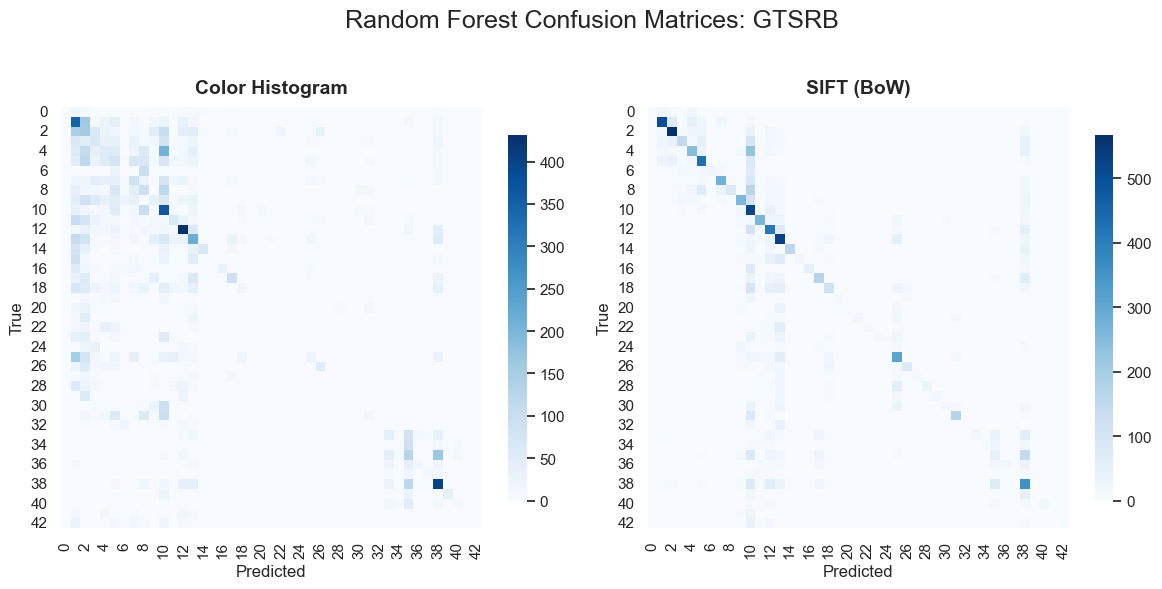


📊 Erstelle 1x2 Plot für CIFAR-10...
💾 Gespeichert: analyse_plot/rf_confusion_1x2_CIFAR-10.png


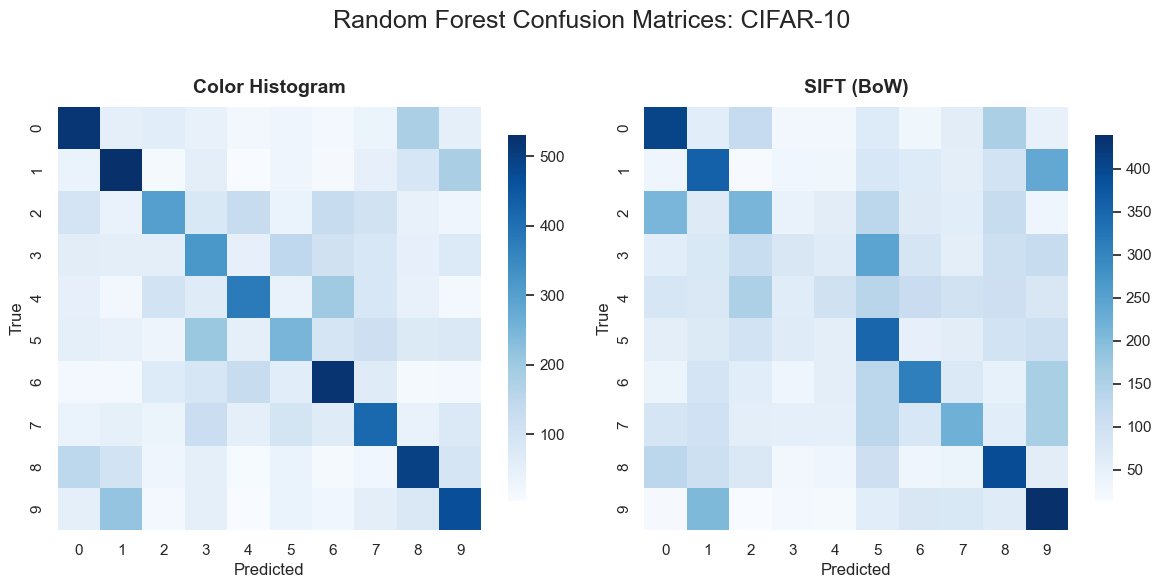

In [86]:
import os
import json
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- KONFIGURATION ---
ROOT_PATH = "./runs_ml"
OUTPUT_FOLDER = "analyse_plot"

def parse_key_to_dict(key_str):
    try:
        return ast.literal_eval(key_str)
    except:
        return None

def find_best_matrix(cm_dict, best_params):
    # Versuch 1: String Match
    if str(best_params) in cm_dict:
        return cm_dict[str(best_params)].get("confusion_matrix")
    # Versuch 2: Dict Match
    for key, val in cm_dict.items():
        if parse_key_to_dict(key) == best_params:
            return val.get("confusion_matrix")
    # Fallback
    first_key = list(cm_dict.keys())[0]
    return cm_dict[first_key].get("confusion_matrix")

def plot_rf_confusion_matrices_1x2(root_path):
    print(f"🔍 Suche nach Random Forest Confusion Matrices in {root_path}...")
    
    data_store = {
        "GTSRB": {"Color Histogram": None, "SIFT (BoW)": None},
        "CIFAR-10": {"Color Histogram": None, "SIFT (BoW)": None}
    }

    # 1. Daten sammeln
    for root, dirs, files in os.walk(root_path):
        if "config.json" in files and "all_confusion_matrices.json" in files:
            try:
                with open(os.path.join(root, "config.json"), 'r') as f:
                    config = json.load(f)
                
                # Filter: Nur Random Forest
                if "rf" not in config.get("model", "").lower() and "random" not in config.get("model", "").lower():
                    continue

                # Datensatz
                ds_raw = config.get("dataset", "").lower()
                path_lower = root.lower()
                if "gtsrb" in ds_raw or "gtsrb" in path_lower: dataset = "GTSRB"
                elif "cifar" in ds_raw or "cifar" in path_lower: dataset = "CIFAR-10"
                else: continue

                # Feature
                feat_raw = config.get("feature", "Unknown")
                if "ColorHist" in feat_raw: feature = "Color Histogram"
                elif "SIFT" in feat_raw: feature = "SIFT (BoW)"
                else: feature = None
                
                if feature:
                    with open(os.path.join(root, "all_confusion_matrices.json"), 'r') as f:
                        cm_data = json.load(f)
                    matrix = find_best_matrix(cm_data, config.get("best_params"))
                    if matrix:
                        data_store[dataset][feature] = matrix
                        print(f"  ✅ Geladen: {dataset} | {feature}")

            except Exception as e:
                print(f"  ❌ Fehler in {root}: {e}")

    # 2. Plotten (1x2 Raster)
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)

    for dataset in ["GTSRB", "CIFAR-10"]:
        mat_hist = data_store[dataset]["Color Histogram"]
        mat_sift = data_store[dataset]["SIFT (BoW)"]
        
        if mat_hist is None and mat_sift is None:
            continue
            
        print(f"\n📊 Erstelle 1x2 Plot für {dataset}...")
        
        # Figure Größe für 2 Quadrate nebeneinander (Breite ca. 2x Höhe)
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        configs = [
            (axes[0], mat_hist, "Color Histogram"),
            (axes[1], mat_sift, "SIFT (BoW)")
        ]
        
        for ax, matrix, title in configs:
            if matrix:
                # Heatmap
                # square=True erzwingt quadratische Zellen -> quadratischer Plot
                # cbar=False hier, wir machen eine gemeinsame oder separate unten
                sns.heatmap(
                    matrix, 
                    annot=False, 
                    fmt='d', 
                    cmap="Blues", 
                    ax=ax,
                    square=True,       # WICHTIG: Macht den Plot quadratisch
                    cbar=True,
                    cbar_kws={"shrink": 0.7} # Colorbar etwas kleiner machen
                )
                ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
                ax.set_xlabel("Predicted")
                ax.set_ylabel("True")
                
                # Optional: Rahmen entfernen für cleaneren Look
                ax.tick_params(left=False, bottom=False)
            else:
                ax.text(0.5, 0.5, "Fehlende Daten", ha='center', va='center')
                ax.axis('off')

        plt.suptitle(f"Random Forest Confusion Matrices: {dataset}", fontsize=18, y=0.98)
        
        # Layout anpassen damit nichts abgeschnitten wird
        plt.tight_layout()
        
        save_path = os.path.join(OUTPUT_FOLDER, f"rf_confusion_1x2_{dataset}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Gespeichert: {save_path}")
        plt.show()

if __name__ == "__main__":
    plot_rf_confusion_matrices_1x2(ROOT_PATH)

🔍 Suche nach Logistic Regression Confusion Matrices in ./runs_ml...
  ✅ Geladen: GTSRB | SIFT (BoW)
  ✅ Geladen: GTSRB | Color Histogram
  ✅ Geladen: CIFAR-10 | SIFT (BoW)
  ✅ Geladen: CIFAR-10 | Color Histogram

📊 Erstelle 1x2 Plot für GTSRB...
💾 Gespeichert: analyse_plot/lr_confusion_1x2_GTSRB.png


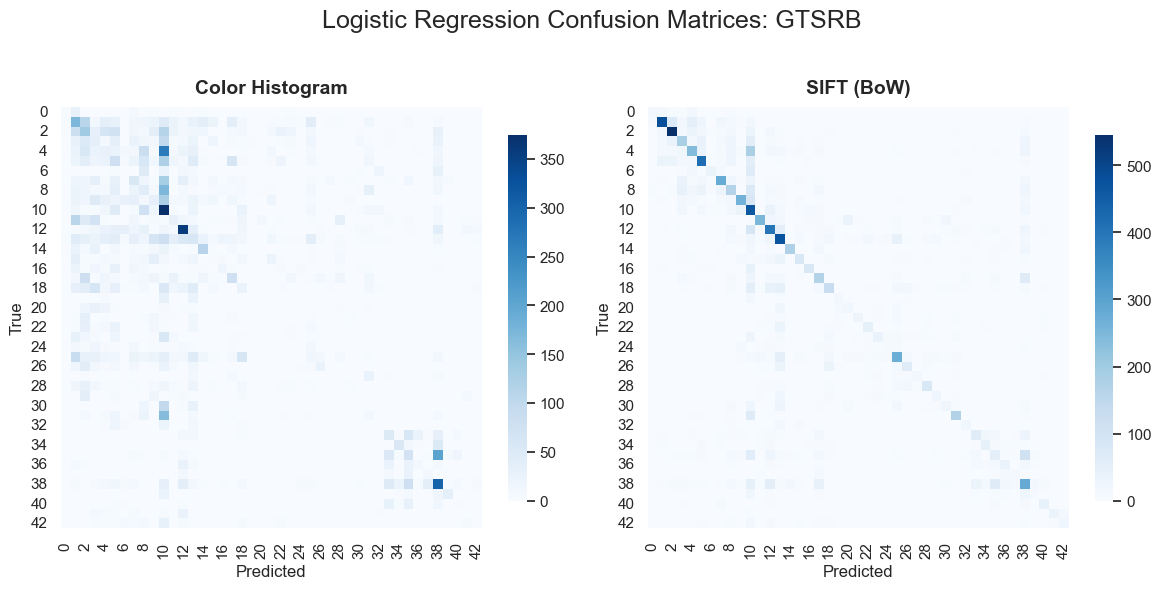


📊 Erstelle 1x2 Plot für CIFAR-10...
💾 Gespeichert: analyse_plot/lr_confusion_1x2_CIFAR-10.png


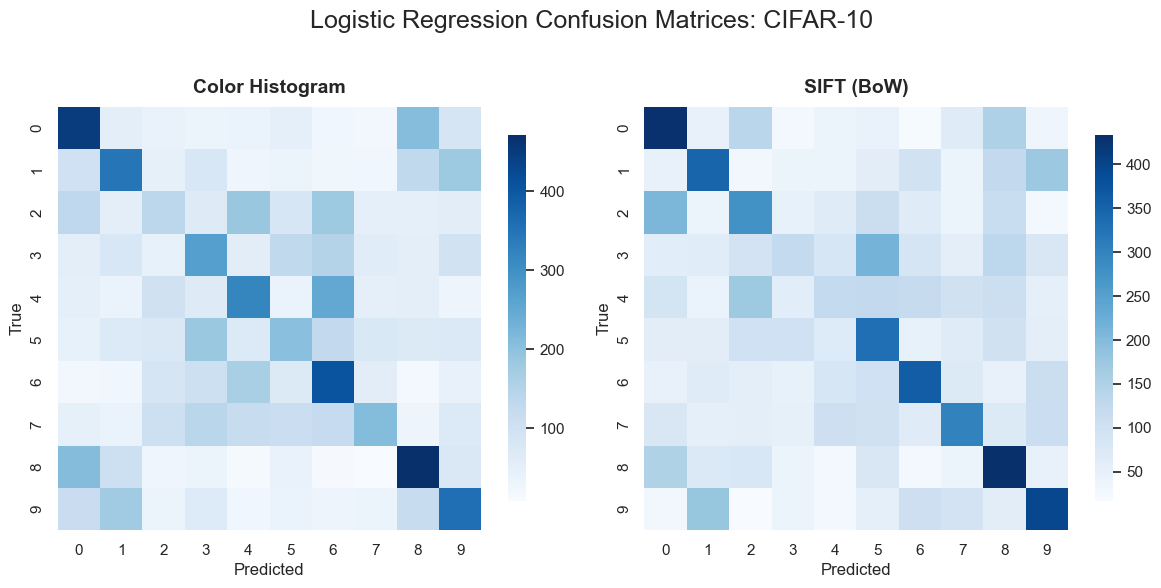

In [87]:
import os
import json
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- KONFIGURATION ---
ROOT_PATH = "./runs_ml"
OUTPUT_FOLDER = "analyse_plot"

def parse_key_to_dict(key_str):
    try:
        return ast.literal_eval(key_str)
    except:
        return None

def find_best_matrix(cm_dict, best_params):
    # Versuch 1: String Match
    if str(best_params) in cm_dict:
        return cm_dict[str(best_params)].get("confusion_matrix")
    
    # Versuch 2: Dict Match
    for key, val in cm_dict.items():
        if parse_key_to_dict(key) == best_params:
            return val.get("confusion_matrix")
    
    # Fallback
    first_key = list(cm_dict.keys())[0]
    return cm_dict[first_key].get("confusion_matrix")

def plot_lr_confusion_matrices_1x2(root_path):
    print(f"🔍 Suche nach Logistic Regression Confusion Matrices in {root_path}...")
    
    data_store = {
        "GTSRB": {"Color Histogram": None, "SIFT (BoW)": None},
        "CIFAR-10": {"Color Histogram": None, "SIFT (BoW)": None}
    }
    
    # 1. Daten sammeln
    for root, dirs, files in os.walk(root_path):
        if "config.json" in files and "all_confusion_matrices.json" in files:
            try:
                with open(os.path.join(root, "config.json"), 'r') as f:
                    config = json.load(f)
                
                # Filter: Nur Logistic Regression
                if "lr" not in config.get("model", "").lower() and "logistic" not in config.get("model", "").lower():
                    continue
                
                # Datensatz
                ds_raw = config.get("dataset", "").lower()
                path_lower = root.lower()
                if "gtsrb" in ds_raw or "gtsrb" in path_lower: dataset = "GTSRB"
                elif "cifar" in ds_raw or "cifar" in path_lower: dataset = "CIFAR-10"
                else: continue
                
                # Feature
                feat_raw = config.get("feature", "Unknown")
                if "ColorHist" in feat_raw: feature = "Color Histogram"
                elif "SIFT" in feat_raw: feature = "SIFT (BoW)"
                else: feature = None
                
                if feature:
                    with open(os.path.join(root, "all_confusion_matrices.json"), 'r') as f:
                        cm_data = json.load(f)
                    
                    matrix = find_best_matrix(cm_data, config.get("best_params"))
                    if matrix:
                        data_store[dataset][feature] = matrix
                        print(f"  ✅ Geladen: {dataset} | {feature}")
                        
            except Exception as e:
                print(f"  ❌ Fehler in {root}: {e}")
    
    # 2. Plotten (1x2 Raster)
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    
    for dataset in ["GTSRB", "CIFAR-10"]:
        mat_hist = data_store[dataset]["Color Histogram"]
        mat_sift = data_store[dataset]["SIFT (BoW)"]
        
        if mat_hist is None and mat_sift is None:
            continue
        
        print(f"\n📊 Erstelle 1x2 Plot für {dataset}...")
        
        # Figure Größe für 2 Quadrate nebeneinander (Breite ca. 2x Höhe)
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        configs = [
            (axes[0], mat_hist, "Color Histogram"),
            (axes[1], mat_sift, "SIFT (BoW)")
        ]
        
        for ax, matrix, title in configs:
            if matrix:
                # Heatmap
                # square=True erzwingt quadratische Zellen -> quadratischer Plot
                # cbar=False hier, wir machen eine gemeinsame oder separate unten
                sns.heatmap(
                    matrix, 
                    annot=False, 
                    fmt='d', 
                    cmap="Blues", 
                    ax=ax,
                    square=True,       # WICHTIG: Macht den Plot quadratisch
                    cbar=True,
                    cbar_kws={"shrink": 0.7} # Colorbar etwas kleiner machen
                )
                ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
                ax.set_xlabel("Predicted")
                ax.set_ylabel("True")
                # Optional: Rahmen entfernen für cleaneren Look
                ax.tick_params(left=False, bottom=False)
            else:
                ax.text(0.5, 0.5, "Fehlende Daten", ha='center', va='center')
                ax.axis('off')
        
        plt.suptitle(f"Logistic Regression Confusion Matrices: {dataset}", fontsize=18, y=0.98)
        
        # Layout anpassen damit nichts abgeschnitten wird
        plt.tight_layout()
        
        save_path = os.path.join(OUTPUT_FOLDER, f"lr_confusion_1x2_{dataset}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Gespeichert: {save_path}")
        plt.show()

if __name__ == "__main__":
    plot_lr_confusion_matrices_1x2(ROOT_PATH)

In [88]:
import json
import pandas as pd
import numpy as np
import os

# --- KONFIGURATION ---
SEARCH_ROOT = "./runs_ml"  # Dein Hauptordner

def generate_multiple_rf_tables(root_path):
    print(f"🚀 Suche nach Summary-Dateien in: {os.path.abspath(root_path)}\n")
    
    # 1. Alle best_summary.csv Dateien finden
    summary_locations = []
    for root, dirs, files in os.walk(root_path):
        if "best_summary.csv" in files:
            csv_path = os.path.join(root, "best_summary.csv")
            # Wir nehmen an, summary.json liegt daneben
            json_path = os.path.join(root, "summary.json") if "summary.json" in files else None
            summary_locations.append((csv_path, json_path))

    if not summary_locations:
        print("❌ Keine 'best_summary.csv' Dateien gefunden.")
        return

    # 2. Für jede gefundene Datei (== Datensatz) eine Tabelle erstellen
    for csv_path, json_path in summary_locations:
        
        # Datensatz-Name aus dem Pfad erraten
        path_lower = csv_path.lower()
        if "gtsrb" in path_lower:
            dataset_name = "GTSRB"
        elif "cifar" in path_lower:
            dataset_name = "CIFAR-10"
        else:
            # Fallback: Ordnername
            dataset_name = os.path.basename(os.path.dirname(csv_path))

        print(f"📊 Generiere Tabelle für Datensatz: {dataset_name}")
        
        # --- A) Daten Laden ---
        df = pd.read_csv(csv_path)
        
        # --- B) Std Dev aus JSON laden ---
        std_map = {} 
        if json_path:
            try:
                with open(json_path, "r") as f:
                    data = json.load(f)
                results = data.get("results", data)
                iterator = results if isinstance(results, list) else (results.values() if isinstance(results, dict) else [])

                for item in iterator:
                    std = item.get("cv_std_test_score", 0.0)
                    m = item.get("model", "")
                    f = item.get("feature", "")
                    
                    # Normalisieren für RF
                    if "RF" in m or "Random" in m: m = "RF"
                    if m and f:
                        std_map[(m, f)] = std
            except:
                pass # Fehler ignorieren, Std bleibt 0

        def get_std_dev(row):
            m_name = "RF" if ("RF" in row["model"] or "Random" in row["model"]) else "Other"
            f_name = row["feature"]
            return std_map.get((m_name, f_name), 0.0)

        df["cv_std"] = df.apply(get_std_dev, axis=1)

        # --- C) Filtern & Formatieren ---
        
        # 1. Modell Namen cleanen
        df["Model"] = df["model"].replace({"RF": "Random Forest"})
        
        # 2. NUR Random Forest filtern
        df = df[df["Model"] == "Random Forest"].copy()
        
        if df.empty:
            print(f"   ⚠️ Keine Random Forest Daten in {dataset_name}. Überspringe...\n")
            continue

        # 3. Features cleanen
        df["Feature"] = df["feature"].replace({
            "ColorHist_bins8": "Color Histogram",
            "SIFT_BoVW": "SIFT (BoW)"
        })
        
        # 4. Werte setzen
        df["Accuracy"] = df["accuracy"]
        df["F1 Score"] = df["f1_macro"]
        df["Train Time (s)"] = df["model_train_time_s"]
        df["Test Time (s)"] = df["model_test_time_s"]
        
        # 5. CV Score Format: "Mean ± Std"
        df["CV Score"] = df.apply(lambda r: f"{r['cv_score']:.4f} $\\pm$ {r['cv_std']:.4f}", axis=1)
        
        # 6. Runden
        df["Accuracy"] = df["Accuracy"].map('{:.4f}'.format)
        df["F1 Score"] = df["F1 Score"].map('{:.4f}'.format)
        df["Train Time (s)"] = df["Train Time (s)"].map('{:.2f}'.format)
        df["Test Time (s)"] = df["Test Time (s)"].map('{:.4f}'.format)

        # --- D) LaTeX Generieren ---
        final_cols = ["Model", "Feature", "Accuracy", "F1 Score", "Train Time (s)", "Test Time (s)", "CV Score"]
        final_df = df[final_cols].sort_values("Feature")
        
        # Header fett
        final_df.columns = [f"\\textbf{{{c}}}" for c in final_df.columns]
        
        # Label dynamisch machen (z.B. tab:rf_gtsrb)
        label_name = f"tab:rf_{dataset_name.lower().replace('-', '')}"
        
        latex_code = final_df.to_latex(
            index=False, 
            escape=False, 
            column_format="llccccc", 
            caption=f"Random Forest Performance on {dataset_name}.", 
            label=label_name
        )
        
        print("\n" + "%" * 40)
        print(f"% LaTeX Table for {dataset_name}")
        print("%" * 40)
        print(latex_code)
        print("\n")

# Ausführen
if __name__ == "__main__":
    generate_multiple_rf_tables(SEARCH_ROOT)

🚀 Suche nach Summary-Dateien in: /Users/Ahnaf/Library/CloudStorage/OneDrive-VerkehrsverbundOst-Region(VOR)GmbH/TU/ML/ML_Ex3/ML_UE3-main/runs_ml

📊 Generiere Tabelle für Datensatz: GTSRB

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% LaTeX Table for GTSRB
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\begin{table}
\caption{Random Forest Performance on GTSRB.}
\label{tab:rf_gtsrb}
\begin{tabular}{llccccc}
\toprule
\textbf{Model} & \textbf{Feature} & \textbf{Accuracy} & \textbf{F1 Score} & \textbf{Train Time (s)} & \textbf{Test Time (s)} & \textbf{CV Score} \\
\midrule
Random Forest & Color Histogram & 0.2313 & 0.1452 & 3.79 & 0.0711 & 0.6464 $\pm$ 0.0000 \\
Random Forest & SIFT (BoW) & 0.4721 & 0.3393 & 1.87 & 0.0485 & 0.5444 $\pm$ 0.0000 \\
\bottomrule
\end{tabular}
\end{table}



📊 Generiere Tabelle für Datensatz: CIFAR-10

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% LaTeX Table for CIFAR-10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\begin{table}
\caption{Random Forest Performance on CIFAR-10.}


In [89]:
import json
import pandas as pd
import numpy as np
import os

# --- KONFIGURATION ---
SEARCH_ROOT = "./runs_ml"  # Dein Hauptordner

def generate_multiple_lr_tables(root_path):
    print(f"🚀 Suche nach Summary-Dateien in: {os.path.abspath(root_path)}\n")
    
    # 1. Alle best_summary.csv Dateien finden
    summary_locations = []
    
    for root, dirs, files in os.walk(root_path):
        if "best_summary.csv" in files:
            csv_path = os.path.join(root, "best_summary.csv")
            # Wir nehmen an, summary.json liegt daneben
            json_path = os.path.join(root, "summary.json") if "summary.json" in files else None
            summary_locations.append((csv_path, json_path))
    
    if not summary_locations:
        print("❌ Keine 'best_summary.csv' Dateien gefunden.")
        return
    
    # 2. Für jede gefundene Datei (== Datensatz) eine Tabelle erstellen
    for csv_path, json_path in summary_locations:
        # Datensatz-Name aus dem Pfad erraten
        path_lower = csv_path.lower()
        if "gtsrb" in path_lower:
            dataset_name = "GTSRB"
        elif "cifar" in path_lower:
            dataset_name = "CIFAR-10"
        else:
            # Fallback: Ordnername
            dataset_name = os.path.basename(os.path.dirname(csv_path))
        
        print(f"📊 Generiere Tabelle für Datensatz: {dataset_name}")
        
        # --- A) Daten Laden ---
        df = pd.read_csv(csv_path)
        
        # --- B) Std Dev aus JSON laden ---
        std_map = {} 
        if json_path:
            try:
                with open(json_path, "r") as f:
                    data = json.load(f)
                
                results = data.get("results", data)
                iterator = results if isinstance(results, list) else (results.values() if isinstance(results, dict) else [])
                
                for item in iterator:
                    std = item.get("cv_std_test_score", 0.0)
                    m = item.get("model", "")
                    f = item.get("feature", "")
                    
                    # Normalisieren für LR
                    if "LR" in m or "Logistic" in m.lower(): m = "LR"
                    
                    if m and f:
                        std_map[(m, f)] = std
            except:
                pass # Fehler ignorieren, Std bleibt 0
        
        def get_std_dev(row):
            m_name = "LR" if ("LR" in row["model"] or "Logistic" in row["model"].lower()) else "Other"
            f_name = row["feature"]
            return std_map.get((m_name, f_name), 0.0)
        
        df["cv_std"] = df.apply(get_std_dev, axis=1)
        
        # --- C) Filtern & Formatieren ---
        # 1. Modell Namen cleanen - alle die mit "LR" beginnen
        df["Model"] = df["model"].apply(lambda x: "Logistic Regression" if x.startswith("LR") or "Logistic" in x else x)
        
        # 2. NUR Logistic Regression filtern
        df = df[df["Model"] == "Logistic Regression"].copy()
        
        if df.empty:
            print(f"   ⚠️ Keine Logistic Regression Daten in {dataset_name}. Überspringe...\n")
            continue
        
        # 3. Features cleanen
        df["Feature"] = df["feature"].replace({
            "ColorHist_bins8": "Color Histogram",
            "SIFT_BoVW": "SIFT (BoW)"
        })
        
        # 4. Werte setzen
        df["Accuracy"] = df["accuracy"]
        df["F1 Score"] = df["f1_macro"]
        df["Train Time (s)"] = df["model_train_time_s"]
        df["Test Time (s)"] = df["model_test_time_s"]
        
        # 5. CV Score Format: "Mean ± Std"
        df["CV Score"] = df.apply(lambda r: f"{r['cv_score']:.4f} $\\pm$ {r['cv_std']:.4f}", axis=1)
        
        # 6. Runden
        df["Accuracy"] = df["Accuracy"].map('{:.4f}'.format)
        df["F1 Score"] = df["F1 Score"].map('{:.4f}'.format)
        df["Train Time (s)"] = df["Train Time (s)"].map('{:.2f}'.format)
        df["Test Time (s)"] = df["Test Time (s)"].map('{:.4f}'.format)
        
        # --- D) LaTeX Generieren ---
        final_cols = ["Model", "Feature", "Accuracy", "F1 Score", "Train Time (s)", "Test Time (s)", "CV Score"]
        final_df = df[final_cols].sort_values("Feature")
        
        # Header fett
        final_df.columns = [f"\\textbf{{{c}}}" for c in final_df.columns]
        
        # Label dynamisch machen (z.B. tab:lr_gtsrb)
        label_name = f"tab:lr_{dataset_name.lower().replace('-', '')}"
        
        latex_code = final_df.to_latex(
            index=False, 
            escape=False, 
            column_format="llccccc", 
            caption=f"Logistic Regression Performance on {dataset_name}.", 
            label=label_name
        )
        
        print("\n" + "%" * 40)
        print(f"% LaTeX Table for {dataset_name}")
        print("%" * 40)
        print(latex_code)
        print("\n")

# Ausführen
if __name__ == "__main__":
    generate_multiple_lr_tables(SEARCH_ROOT)

🚀 Suche nach Summary-Dateien in: /Users/Ahnaf/Library/CloudStorage/OneDrive-VerkehrsverbundOst-Region(VOR)GmbH/TU/ML/ML_Ex3/ML_UE3-main/runs_ml

📊 Generiere Tabelle für Datensatz: GTSRB

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% LaTeX Table for GTSRB
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\begin{table}
\caption{Logistic Regression Performance on GTSRB.}
\label{tab:lr_gtsrb}
\begin{tabular}{llccccc}
\toprule
\textbf{Model} & \textbf{Feature} & \textbf{Accuracy} & \textbf{F1 Score} & \textbf{Train Time (s)} & \textbf{Test Time (s)} & \textbf{CV Score} \\
\midrule
Logistic Regression & Color Histogram & 0.1767 & 0.1224 & 2137.74 & 0.0111 & 0.3634 $\pm$ 0.0000 \\
Logistic Regression & SIFT (BoW) & 0.4975 & 0.4268 & 444.64 & 0.0046 & 0.5612 $\pm$ 0.0000 \\
\bottomrule
\end{tabular}
\end{table}



📊 Generiere Tabelle für Datensatz: CIFAR-10

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% LaTeX Table for CIFAR-10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\begin{table}
\caption{Logistic Regressi